# $\Lambda$CDM profile

This notebook uses the profile in the `lcdm_example` directory to demonstrate Procoli outputs and plotting functionality. 

The profile can be reproduced using a clean version of CLASS, as well as modified versions of CLASS that reduce to $\Lambda$CDM. 

For posterity and to show what code output looks like, we include a full work session within this notebook.  
This requires working versions of MontePython, CLASS and the included likelihoods.  
As the folder already contains a full calculation of the desired profile, this notebook will not rerun the profile, as long as the relevant files are still accessible from `lcdm_example`. 

Instead, if you just want to run the plotting functions, skip to that section of the notebook. 

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import to_hex
from matplotlib import colormaps

In [115]:
from procoli import lkl_prof
from procoli.procoli_io import get_MP_bf_dict
from procoli.procoli_plots import plot_profile_list, plot_profile_and_parabola_diff_list, get_SA_step_chains_chi2, plot_SA_min_chains, get_SA_step_chains, plot_SA_chains

In [3]:
# %matplotlib widget
%matplotlib inline

### Set up likelihood profile

This is the bare minimum amount of information required to initialize the profile and for the plotting functionality. 

In [6]:
lcdm_H0 = lkl_prof('./lcdm_example/', 'H0')

### Run the likelihood profile

In this case, no optimizations are performed, but all run variables such as the global best fit are set up. 

In [163]:
lcdm_H0.prof_incr = 0.1
lcdm_H0.prof_max = 70.
lcdm_H0.prof_min = 65.
lcdm_H0.processes = 2

In [164]:
lcdm_H0.global_min(N_min_steps=4000);

check_global_min: Found minimum with file name lcdm_example
check_global_min: Found covmat with file name lcdm_example
check_global_min: WARNING!!!: global_min folder found with a global_min.bestfit that was found to be as good or a better chi^2 than the lcdm_example.bestfit file. Code will replace the lcdm_example.bestfit and lcdm_example.log files with ones from the global_min/global_min.bestfit and .log going forward.


CalledProcessError: Command 'mpirun -np 1 MontePython.py -N 1 -f 0 --display-each-chi2 -o ./lcdm_example/chi2_per_exp/ -p ./lcdm_example/log.param -b ./lcdm_example/chi2_per_exp/chi2_per_exp.bestfit' returned non-zero exit status 1.

In [165]:
lcdm_H0.global_ML;

AttributeError: 'lkl_prof' object has no attribute 'global_ML'

In [ ]:
lcdm_H0.init_lkl_prof()

In [ ]:
lcdm_H0.run_lkl_prof(time_mins=True);

### Analyse the output

Get a dictionary with keys of all parameters in the likelihood profile, and values of arrays of parameter values along the profile

In [166]:
lcdm_H0_dict = lcdm_H0.full_lkl_prof_dict()

Then plot this profile

#### Plot full profiles

The profiles can easily be plot using the dictionary of arrays `lcdm_H0_dict`.  
Then, slicing the profile at $\Delta \chi^2 = 1$ relative to the minimum $\chi^2_{\rm min}$ provides the $1\sigma$ constraint. 

(3809.498884052835, 3853.979339149132)

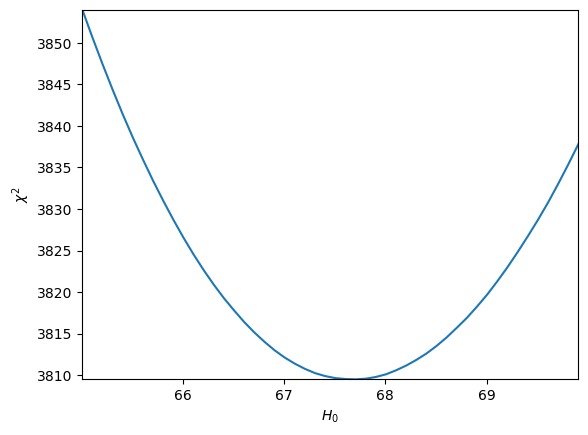

In [167]:
plt.plot(lcdm_H0_dict['H0'], lcdm_H0_dict['Total'])

plt.xlabel(r'$H_0$')
plt.ylabel(r'$\chi^2$')

plt.xlim([min(lcdm_H0_dict['H0']), max(lcdm_H0_dict['H0'])])
plt.ylim([min(lcdm_H0_dict['Total']), max(lcdm_H0_dict['Total'])])

The following is a quick function to plot several profiles at once for comparison

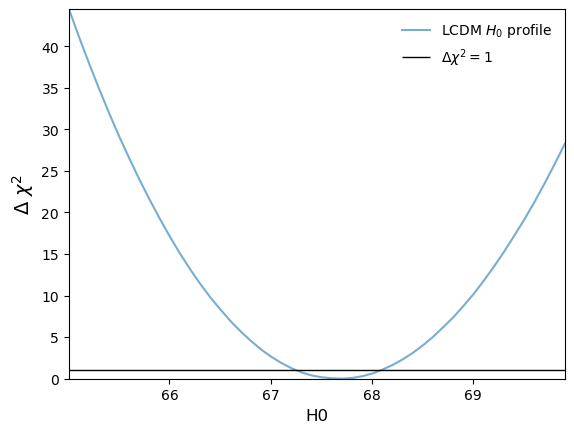

In [168]:
# colours = ['cornflowerblue']

plot_profile_list( 
    [lcdm_H0_dict], 
    'H0', 
    # y_chi2='-logLike', 
    # x_label=r'$H_0$', 
    # y_label=r'$\chi^2$', 
    legend_list=[r'LCDM $H_0$ profile'], 
    # colours=colours, 
    # norm_to_min=False
)

plt.hlines(y=1, xmin=-100, xmax=100, lw=1, color='k', label=r'$\Delta \chi^2 = 1$')
plt.legend(frameon=False)

plt.show()

By default, it will plot $2\times -\log \mathcal{L}$ and subtract the minimum $\chi^2$ of each curve, but this can be modified to any other parameter. 

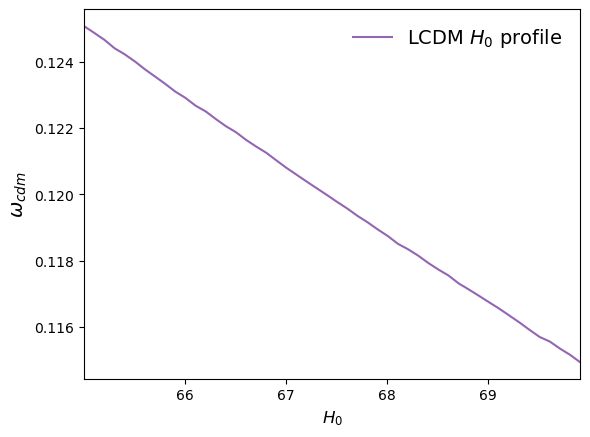

In [169]:
colours = ['indigo']

plot_profile_list( 
    [lcdm_H0_dict], 
    'H0', 
    y_chi2='omega_cdm', 
    x_label=r'$H_0$', 
    y_label=r'$\omega_{cdm}$', 
    legend_list=[r'LCDM $H_0$ profile'], 
    colours=colours, 
    norm_to_min=False
)
plt.show()

Neither the $x$ nor the $y$ parameter need be the profile likelihood parameter

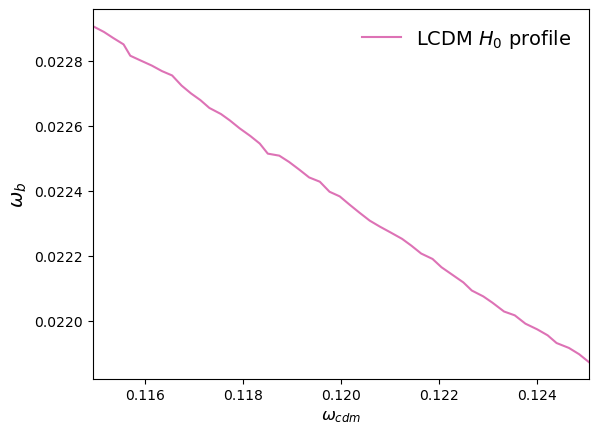

In [170]:
colours = ['mediumvioletred']

plot_profile_list( 
    [lcdm_H0_dict], 
    'omega_cdm', 
    y_chi2='omega_b', 
    x_label=r'$\omega_{cdm}$', 
    y_label=r'$\omega_{b}$', 
    legend_list=[r'LCDM $H_0$ profile'], 
    colours=colours, 
    norm_to_min=False
)
plt.show()

If you are confident that your profile produced should be quadratic in $\chi^2$ i.e. Gaussian in $\mathcal{L}$, the following compares a profile to a quadratic curve

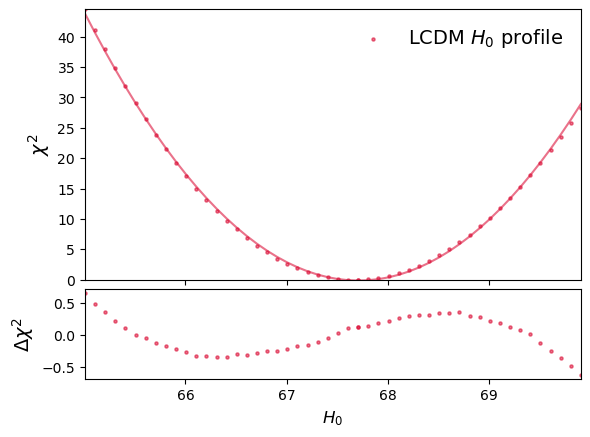

In [171]:
colours = ['crimson']

plot_profile_and_parabola_diff_list( 
    [lcdm_H0_dict], 
    'H0', 
    x_label=r'$H_0$', 
    legend_list=[r'LCDM $H_0$ profile'], 
    colours=colours, 
    norm_to_min=True
                                   )
plt.show()

#### Split $\chi^2$ per experiment

We start by checking which experiments were used for this profile

In [172]:
experiments = list(lcdm_H0_dict)[list(lcdm_H0_dict).index('-logLike')+1:]
experiments

['Planck_highl_TTTEEE',
 'Planck_lowl_EE',
 'Planck_lowl_TT',
 'Planck_lensing',
 'bao_smallz_2014',
 'bao_fs_boss_dr12',
 'Pantheon',
 'Total']

In [173]:
x = lcdm_H0_dict['H0']

We can then plot all experiments separately

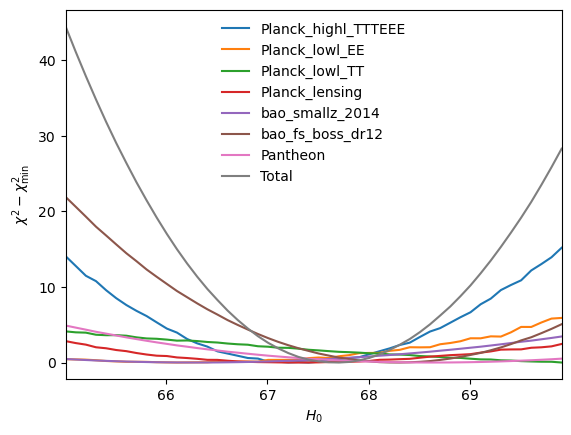

In [174]:
for exp in experiments:
    plt.plot(x, lcdm_H0_dict[exp]-min(lcdm_H0_dict[exp]), 
             label=exp
            )

plt.ylabel(r'$\chi^2 - \chi^2_{\rm min}$')
plt.xlabel(r'$H_0$')
plt.xlim([min(x), max(x)])
plt.legend(frameon=False)

Or, different experiments can be combined under one umbrella to clean up the plot above 

In [175]:
cmb_exps = [
 'Planck_highl_TTTEEE',
 'Planck_lowl_EE',
 'Planck_lowl_TT',
 'Planck_lensing',
]
cmb_chi2 = sum(lcdm_H0_dict[i] for i in cmb_exps)

In [176]:
bao_exps = [
 'bao_smallz_2014',
 'bao_fs_boss_dr12',
]
bao_chi2 = sum(lcdm_H0_dict[i] for i in bao_exps)

In [177]:
sne_chi2 = lcdm_H0_dict['Pantheon']

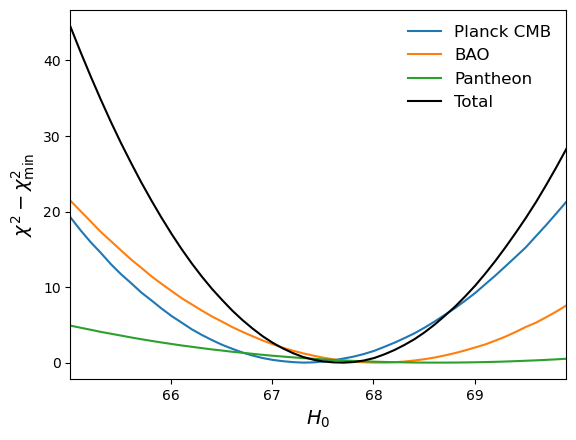

In [178]:
plt.plot(x, cmb_chi2-min(cmb_chi2), 
         label='Planck CMB')
plt.plot(x, bao_chi2-min(bao_chi2), 
         label='BAO')
plt.plot(x, sne_chi2-min(sne_chi2), 
         label='Pantheon')

plt.plot(x, lcdm_H0_dict['Total']-min(lcdm_H0_dict['Total']), 
         label='Total', c='k')

plt.ylabel(r'$\chi^2 - \chi^2_{\rm min}$', fontsize=14)
plt.xlabel(r'$H_0$', fontsize=14)
plt.xlim([min(x), max(x)])
plt.legend(frameon=False, fontsize=12)

Or we can investigate just a subset of these experiments to further examine their contribution to the profile

In [179]:
cmb_exps = [
 'Planck_highl_TTTEEE',
 'Planck_lowl_EE',
 'Planck_lowl_TT',
 'Planck_lensing',
]

In [180]:
cmb_chi2 = sum(lcdm_H0_dict[i] for i in cmb_exps)

In [181]:
labels = [
    r'High-$\ell$ TTTEEE', 
    r'Low-$\ell$ EE', 
    r'Low-$\ell$ TT', 
    'Lensing'
]

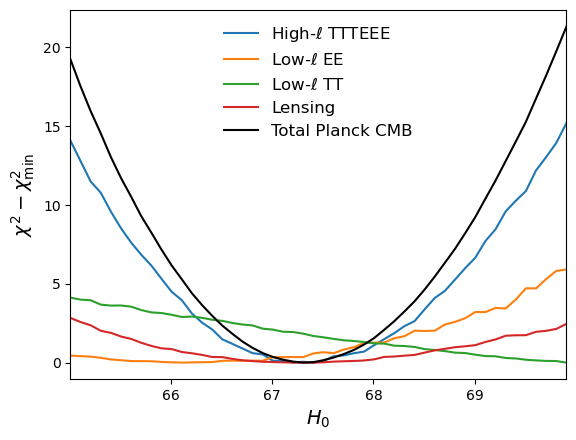

In [182]:
for i in range(len(cmb_exps)):
    plt.plot(x, lcdm_H0_dict[cmb_exps[i]]-min(lcdm_H0_dict[cmb_exps[i]]), 
             label=labels[i],)
plt.plot(x, cmb_chi2-min(cmb_chi2), label='Total Planck CMB', c='k',)

plt.ylabel(r'$\chi^2 - \chi^2_{\rm min}$', fontsize=14)
plt.xlabel(r'$H_0$', fontsize=14)
plt.xlim([min(x), max(x)])
plt.legend(frameon=False, fontsize=12)

#### Plot progression of optimizer

Procoli also allows quick plotting of the progression of the optimizer. 

First we look at the $\chi^2$ progression of the global best fit and the last iteration of the profile liklihood optimization 

In [183]:
global_min_chi2_per_step = get_SA_step_chains_chi2('./lcdm_example/global_min/', chains_per_step=6, chain_len=4000)

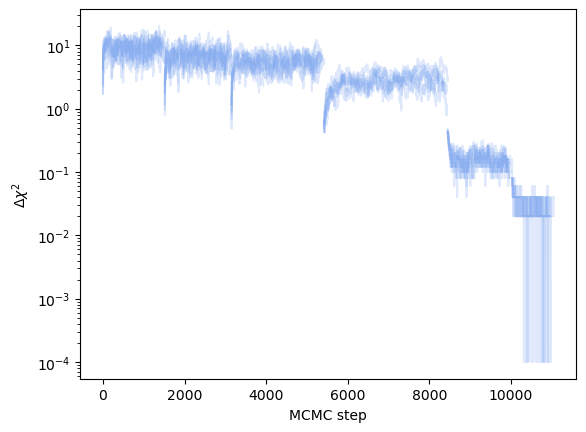

In [184]:
plot_SA_min_chains(global_min_chi2_per_step)

plt.yscale('log')

plt.show()

In [185]:
global_min_chi2_per_step = get_SA_step_chains_chi2('./lcdm_example/lkl_prof_-H0/', chains_per_step=6, chain_len=1500)

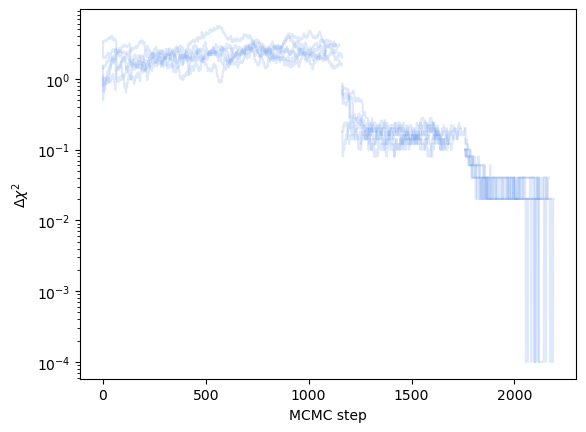

In [186]:
plot_SA_min_chains(global_min_chi2_per_step)

plt.yscale('log')

plt.show()

Such plots can also be made for any other parameter in the chains

In [187]:
params, global_min_chains_per_step = get_SA_step_chains('./lcdm_example/global_min/', chains_per_step=6, chain_len=4000)
params;

The `params` list records all the parameters that such a plot can readily be constructed for 

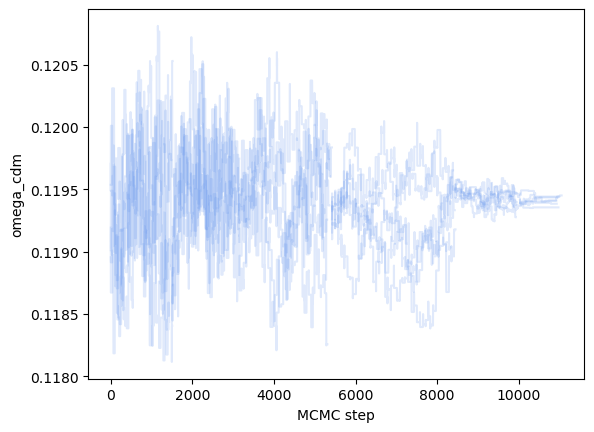

In [188]:
plot_SA_chains(global_min_chains_per_step, param_list=params, param_to_plot='omega_cdm', alpha=0.2, 
                   colour='cornflowerblue', )
plt.show()